In [77]:
full.to_csv('data/runs/full.csv')
clean.to_csv('data/runs/clean.csv', index=False)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from scipy import stats

In [2]:
data = pd.read_csv('data/runs/n_results.csv', index_col='run')
drug_data = pd.read_csv('full_drug_new.csv')
#drug_data = pd.read_csv('data/runs/drug_data.csv')

# Data cleaning

In [3]:
data = data[data['status']=='completed']
data = data[data['r_2_mean'].notnull()]

data['time'] = pd.to_timedelta(data['time'])
data['started'] = pd.to_datetime(data['started'])
data['seconds'] = data['time'].apply(lambda x:x.seconds)

data['datasets'] = data['gdsc']+data['ctrp']+data['ccle']
data = data[data['datasets']>0]

# The only valid daata
ndata = data[data['started'] > pd.to_datetime('2020-04-15 18:00:00')]

# Joint drug data
drug_data_j = drug_data.join(ndata, rsuffix='_drug', on='run')
drug_data_j = drug_data_j[drug_data_j['started'].notnull()]
ndrug_data = drug_data_j[drug_data_j['started'] > pd.to_datetime('2020-04-15 18:00:00')]
full_data = drug_data.join(data, on='run', rsuffix='_drug')

In [4]:
ndata.describe()

,time,ajive,cutoff,drugs,n,test,threshold,step,r_2_mean,r_2_std,seconds
count,5341,3253.000000,5341.0,5341.000000,5341.000000,0.0,5.341000e+03,5341.0,5341.000000,5340.000000,5341.000000
mean,0 days 00:57:58.619546,2.010144,4.0,19.996443,0.098207,NaN,1.000000e-02,0.0,0.033973,0.344469,3316.852088
std,0 days 01:59:43.764923,0.812848,0.0,0.259981,0.056780,NaN,1.734886e-18,0.0,1.889137,8.390248,5695.418557
min,0 days 00:00:33,1.000000,4.0,1.000000,0.000853,NaN,1.000000e-02,0.0,-136.615707,0.000876,33.000000
25%,0 days 00:09:18,1.000000,4.0,20.000000,0.048426,NaN,1.000000e-02,0.0,-0.031964,0.097725,558.000000
50%,0 days 00:29:49,2.000000,4.0,20.000000,0.097511,NaN,1.000000e-02,0.0,0.086542,0.132590,1789.000000
75%,0 days 01:03:43,3.000000,4.0,20.000000,0.146495,NaN,1.000000e-02,0.0,0.176236,0.204099,3823.000000
max,1 days 17:43:37,3.000000,4.0,20.000000,0.199802,NaN,1.000000e-02,0.0,0.432360,609.875488,82747.000000


# IC/EC quality effect on r2

In [5]:
drugs = drug_data.groupby('Drug').agg({'r2_score': ['mean', 'std']})
drugs['runs'] = [drug_data[drug_data['Drug']==i].shape[0] for i in drugs.index]
one = drugs[drugs['runs']<50].sort_values(by=('r2_score', 'mean'), ascending=False)
multiple = drugs[drugs['runs']>50].sort_values(by=('r2_score', 'mean'), ascending=False)

In [2]:
ctrp = pd.read_csv('data/Processed/ctrp_poz_dr.csv')
gdsc = pd.read_csv('data/Processed/gdsc_poz_dr.csv')
ccle = pd.read_csv('data/Processed/ccle_poz_dr.csv')

In [9]:
pd.concat([ctrp, gdsc, ccle], sort=True)[['AUC_EC50', 'AUC_IC50']].corr()

,AUC_EC50,AUC_IC50
AUC_EC50,1.000000,0.987027
AUC_IC50,0.987027,1.000000


In [7]:
scoring = {'Low':-1, 'Medium':0, 'High':1}
ctrp['IC'] = ctrp['IC50_quality'].replace(scoring)
gdsc['IC'] = gdsc['IC50_quality'].replace(scoring)
gdsc['IC'] = gdsc['IC50_quality'].replace(scoring)

ctrp['EC'] = ctrp['EC50_quality'].replace(scoring)
gdsc['EC'] = gdsc['EC50_quality'].replace(scoring)
gdsc['EC'] = gdsc['EC50_quality'].replace(scoring)

In [8]:
dr = pd.concat([ctrp, gdsc, ccle], sort=True)

In [9]:
c_dict = pd.concat([ctrp, gdsc, ccle], sort=True).groupby('Drug_name').mean()[['IC', 'EC', 'IC50_residual_standard_error', 'EC50_residual_standard_error']]

In [10]:
#c_dict = pd.concat([ctrp, gdsc, ccle], sort=True).groupby('Drug_name').mean()[['IC', 'EC', 'IC50_residual_standard_error', 'EC50_residual_standard_error']]

In [11]:
full = drug_data.join(data, on='run', rsuffix='_drug')
full = full[full['started'] > pd.to_datetime('2020-04-15 18:00:00')]
full['Quality'] = [c_dict.loc[full.loc[i]['Drug']]['IC'] if full.loc[i]['metric_drug']=='AUC_IC50' else c_dict.loc[full.loc[i]['Drug']]['EC'] for i in full.index]
#full['Error'] = [c_dict.loc[full.loc[i]['Drug']]['IC50_residual_standard_error'] if full.loc[i]['metric_drug']=='AUC_IC50' else c_dict.loc[full.loc[i]['Drug']]['EC50_residual_standard_error'] for i in full.index]

In [12]:
full['Quality'] = full['Quality'].fillna(-1)

In [13]:
#full.to_csv('data/runs/full.csv',index=False)

In [14]:
#sns.relplot(x='Error', y='r2_score', data=full[full['r2_score']>-20], kind='scatter', height=9, col='metric_drug', hue='metric_drug', legend=False)

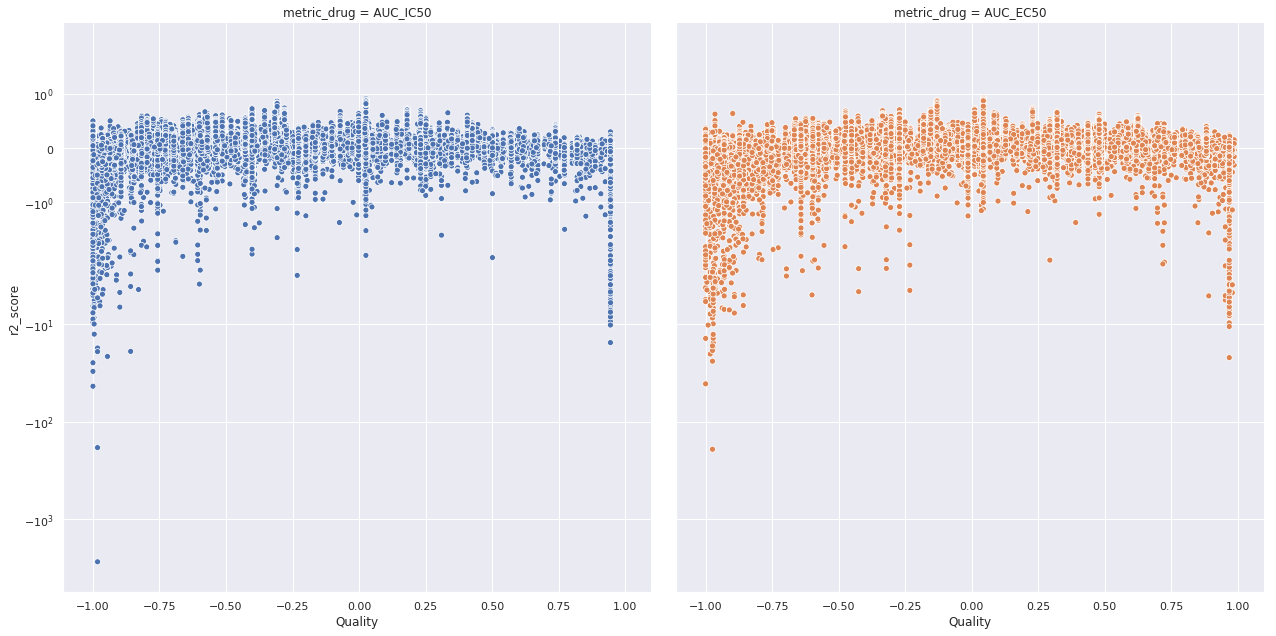

In [15]:
sns.set()
g = sns.relplot(x='Quality', y='r2_score', data=full, kind='scatter', height=9, col='metric_drug', hue='metric_drug', legend=False)
g.set(yscale='symlog')
g.set(ylim=(None, 3))
plt.savefig('IC quality vs r2.png')

In [16]:
drug_ic = full.groupby('Drug').mean()

In [17]:
drug_ic['CCLs'] = [dr[dr['Drug_name']==i].shape[0] for i in drug_ic.index]

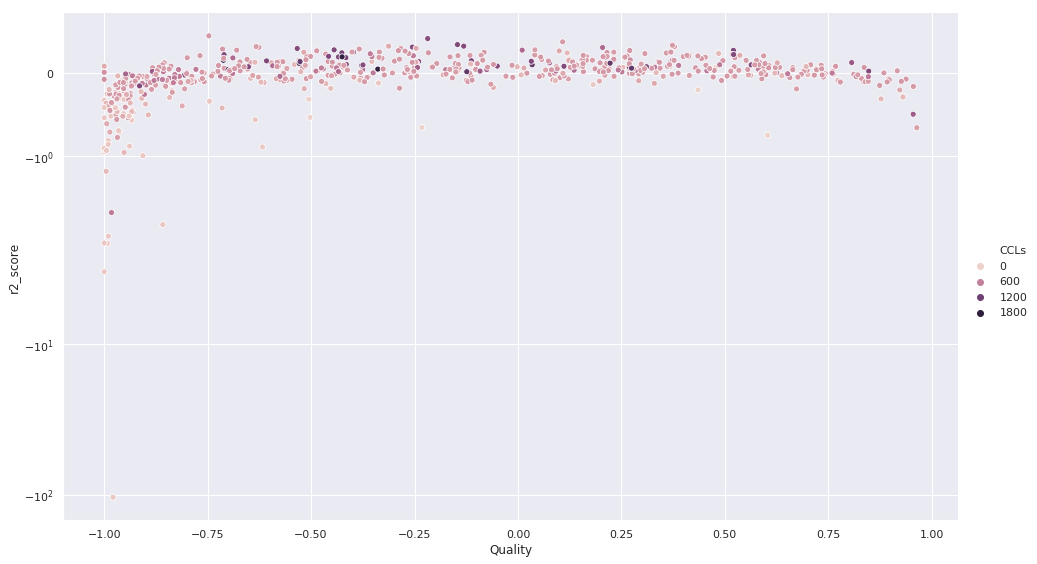

In [18]:
sns.set(font_scale=1)
g = sns.relplot(x='Quality', y='r2_score', data=drug_ic, hue='CCLs', kind='scatter', height=8, aspect=1.7)
g.set(yscale='symlog')
#plt.legend(loc = 'lower right')
#plt.savefig('ICqualitylog.png')

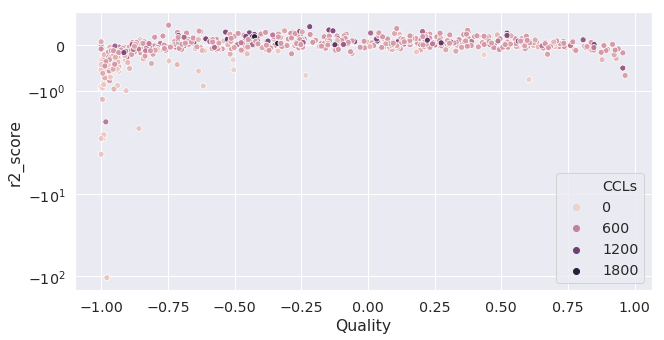

In [19]:
sns.set(font_scale=1.3)
fig, ax = plt.subplots(figsize=(1.9*5,5))
g = sns.scatterplot(x='Quality', y='r2_score', data=drug_ic, hue='CCLs', ax=ax, legend='brief')
g.set(yscale='symlog')
plt.legend(loc='lower right')
plt.tight_layout()
#plt.savefig('graphs/ICqualitylog.eps', format='eps')

## A threshold of -0.75 IC quality is set 
All runs below that are disregarded

In [20]:
clean = full[full['Quality']>-0.95]

In [21]:
clean = clean[clean['started'] > pd.to_datetime('2020-04-15 18:00:00')]
clean['norm'] = clean['norm'].fillna('None')
d_r = clean[['Drug', 'r2_score']].groupby('Drug').mean()

In [22]:
clean['r2'] = [clean.loc[i]['r2_score']-d_r.loc[clean.loc[i]['Drug']]['r2_score'] for i in clean.index]

In [46]:
clean['da'] = ['feda' if clean.loc[i]['feda'] else 'ajive' if clean.loc[i]['ajive'] is not None and clean.loc[i]['ajive']>0 else 'none' for i in clean.index]

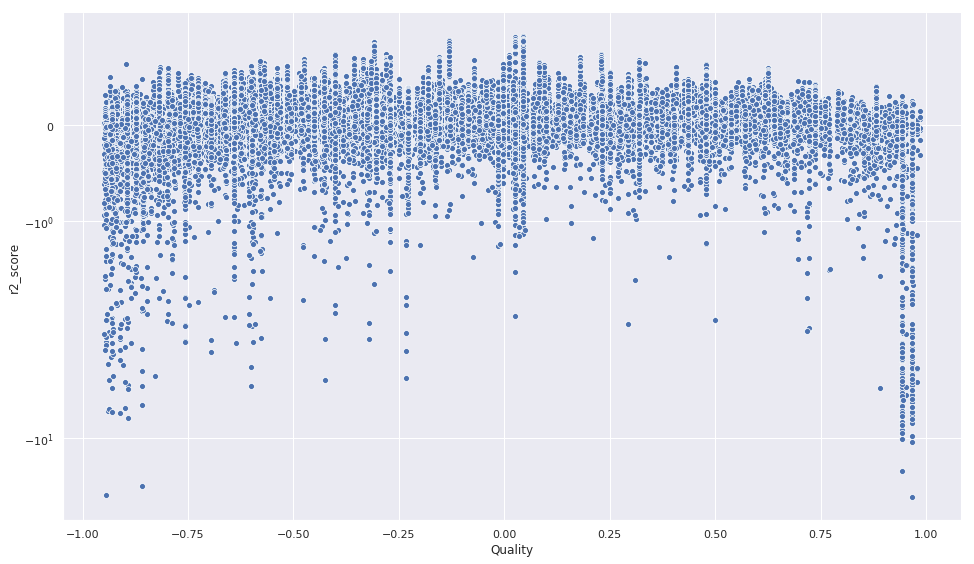

In [25]:
sns.set(font_scale=1)
g = sns.relplot(x='Quality', y='r2_score', data=clean, kind='scatter', height=8, aspect=1.7)
g.set(yscale='symlog')
#plt.legend(loc = 'lower right')
#plt.savefig('Chop.png')

# IC vs EC

In [301]:
clean[clean['metric_drug']=='AUC_IC50'].describe()[['r2_score', 'seconds', 'Quality']]

,r2_score,seconds,Quality
count,46421.000000,46421.000000,46421.000000
mean,0.071301,3312.546865,-0.274012
std,0.331544,5412.890111,0.457943
min,-18.884530,33.000000,-0.948357
25%,-0.015882,569.000000,-0.641654
50%,0.063436,1829.000000,-0.402204
75%,0.194254,3862.000000,0.021767
max,0.904298,65480.000000,0.945882


In [302]:
clean[clean['metric_drug']=='AUC_EC50'].describe()[['r2_score', 'seconds', 'Quality']]

,r2_score,seconds,Quality
count,46222.000000,46222.000000,46222.000000
mean,0.065230,3533.341764,-0.085639
std,0.326819,5462.023423,0.498583
min,-21.885501,34.000000,-0.947826
25%,-0.020336,562.000000,-0.451910
50%,0.056159,1831.000000,-0.162907
75%,0.190307,4146.000000,0.320562
max,0.930501,70690.000000,0.985882


In [307]:
clean.shape

(92643, 74)

In [306]:
from scipy import stats
stats.ttest_ind(clean[clean['metric_drug']=='AUC_IC50']['r2_score'], clean[clean['metric_drug']=='AUC_EC50']['r2_score'], equal_var=False)

Ttest_indResult(statistic=2.8067901027937294, pvalue=0.005004828065933915)

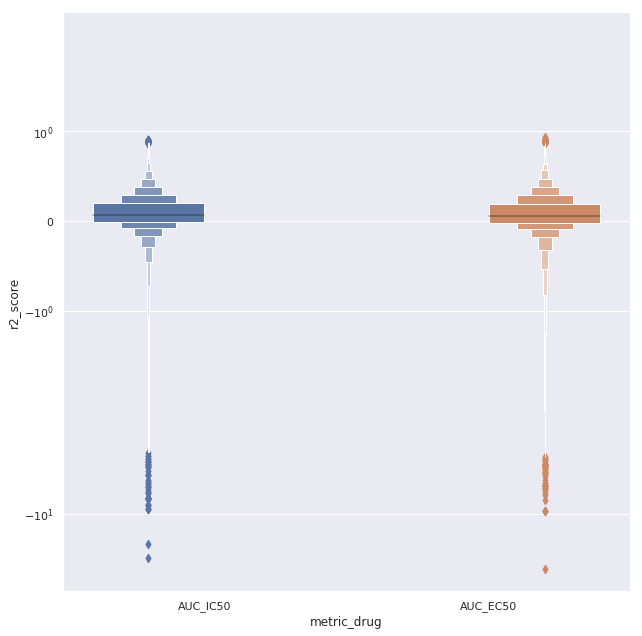

In [304]:
sns.set()
g = sns.catplot(x='metric_drug', y='r2_score', data=clean, kind='boxen', height=9, hue='metric_drug', legend=False)
g.set(yscale='symlog')
g.set(ylim=(None, 3))

# Per model

In [338]:
nmodels = clean.groupby('model').median()
nmodels['Number of runs'] = [clean[(clean['model']==i) & (clean['started'] > pd.to_datetime('2020-04-15 18:00:00'))].shape[0] for i in nmodels.index]
nmodels[['r2_score', 'r_2_std', 'seconds']]

,r2_score,r_2_std,seconds
model,,,
DecisionTreeRegressor,-0.023555,0.196913,1113.0
ElasticNet,0.086431,0.098352,1822.0
KNeighborsRegressor,0.096355,0.117548,6736.0
RandomForestRegressor,0.106153,0.117058,3104.0
SVR,0.084323,0.223175,1120.0


# AJIVE analysis

In [40]:
many = clean[clean['datasets']>1]
many.describe()[['r_2_mean', 'r_2_std', 'seconds']]

,r_2_mean,r_2_std,seconds
count,46164.000000,46164.000000,46164.000000
mean,0.104573,0.129907,4438.975479
std,0.147335,0.115343,6345.421558
min,-0.387880,0.000876,58.000000
25%,-0.010301,0.054506,847.000000
50%,0.097609,0.114628,2820.000000
75%,0.235686,0.184051,5333.000000
max,0.432360,1.608504,70690.000000


In [41]:
ajive = clean[(clean['ajive'].notnull())& (clean['datasets']>1)]
ajive.describe()[['r_2_mean', 'r_2_std', 'seconds']]

,r_2_mean,r_2_std,seconds
count,14783.000000,14783.000000,14783.000000
mean,0.160139,0.169731,3711.378002
std,0.123742,0.106659,6049.571043
min,-0.387880,0.011713,58.000000
25%,0.086991,0.105944,742.000000
50%,0.178575,0.146924,2330.000000
75%,0.249746,0.210757,4243.000000
max,0.432360,1.608504,70690.000000


# Hard to predict drugs

In [42]:
ctrp_low = ctrp[ctrp['IC50_quality']=='Low']['Drug_name'].unique()
gdsc_low = gdsc[gdsc['IC50_quality']=='Low']['Drug_name'].unique()
ccle_low = ccle[ccle['IC50_quality']=='Low']['Drug_name'].unique()

In [43]:
#low_ic = np.concatenate([ctrp_low, gdsc_low, ccle_low])

In [44]:
ic_dict = pd.concat([ctrp, gdsc, ccle]).groupby('Drug_name').mean()[['IC']]

/rwthfs/rz/cluster/home/kz035322/Thesis/venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [49]:
one['IC'] = [ic_dict.loc[i]['IC'] for i in one.index]
one['CCLs'] = [dr[dr['Drug_name']==i].shape[0] for i in one.index]

In [50]:
multiple['IC'] = [ic_dict.loc[i]['IC'] for i in multiple.index]
multiple['CCLs'] = [dr[dr['Drug_name']==i].shape[0] for i in multiple.index]

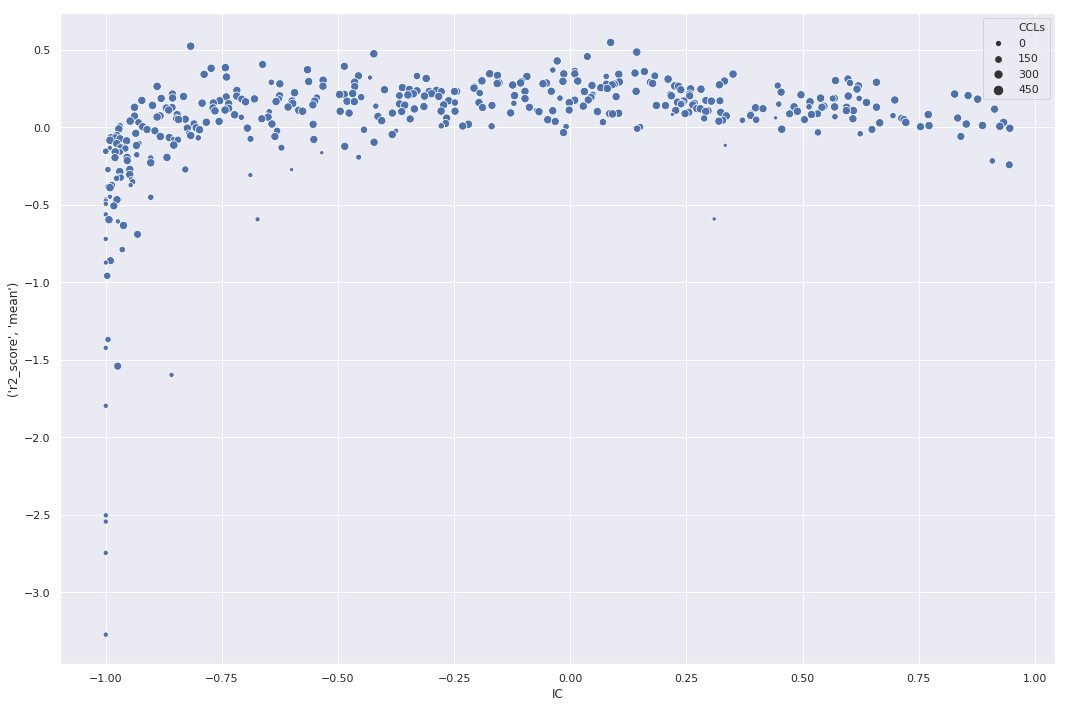

In [51]:
fig, ax = plt.subplots(figsize=(15,10))
sns.scatterplot(x='IC', y=('r2_score', 'mean'), size='CCLs', data=one[one['r2_score']['mean']>-20], ax=ax)
plt.tight_layout()
#plt.savefig('IC quality vs r2.png')

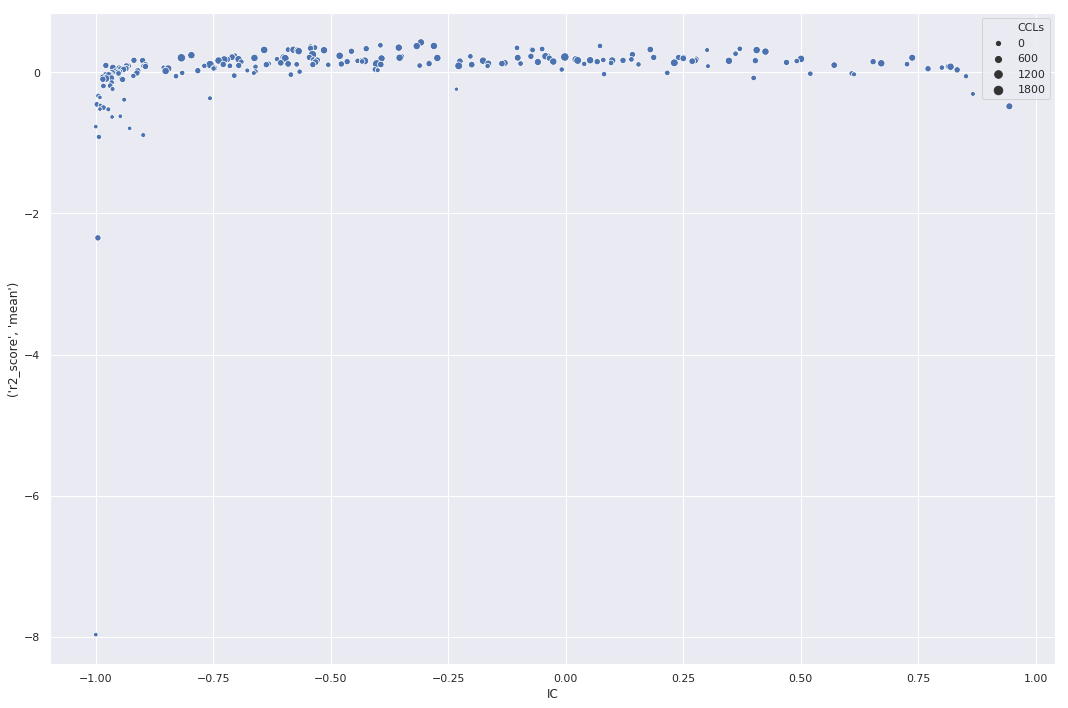

In [52]:
fig, ax = plt.subplots(figsize=(15,10))
sns.scatterplot(x='IC', y=('r2_score', 'mean'), size='CCLs', data=multiple[multiple['r2_score']['mean']>-20], ax=ax)
plt.tight_layout()

In [53]:
drugs.sort_values(('r2_score', 'mean')).head()

r2_score             runs
                     mean         std     
Drug                                      
BRD-K13185470 -129.589152  488.806251   31
BRD-K27986637   -7.967519   28.643415   60
BRD-K44224150   -3.274224    7.224934   39
BRD-K78574327   -2.746796    4.450761   34
ML312           -2.544982    7.871729   49

In [54]:
outliers = pd.DataFrame(columns=['ctrp', 'datasets', 'r2_score'])
for i in drugs[drugs['runs']<50].index:
    dr = drug_data_j[drug_data_j['Drug']==i]
    
    outliers.loc[i] = [dr['ctrp'].mean(), dr['datasets'].mean(), dr['r2_score'].mean()]

In [55]:
outliers.describe()

,ctrp,datasets,r2_score
count,400.0,400.0,400.000000
mean,1.0,1.0,-0.426818
std,0.0,0.0,7.342537
min,1.0,1.0,-146.725947
25%,1.0,1.0,-0.099380
50%,1.0,1.0,0.007636
75%,1.0,1.0,0.097420
max,1.0,1.0,0.441915


In [56]:
one.describe()

r2_score                    runs          IC        CCLs
             mean         std                                    
count  400.000000  400.000000  400.000000  400.000000  400.000000
mean    -0.302478    1.665902   37.457500   -0.265656  367.675000
std      6.493200   24.428444    6.903792    0.569189  103.310464
min   -129.589152    0.053229   16.000000   -1.000000   39.000000
25%     -0.016140    0.236596   33.000000   -0.822031  369.250000
50%      0.108657    0.301589   38.000000   -0.322631  419.000000
75%      0.209991    0.381166   43.000000    0.217922  430.000000
max      0.546171  488.806251   49.000000    0.945882  447.000000

In [57]:
multiple.describe()

r2_score                     runs          IC         CCLs
             mean         std                                      
count  215.000000  215.000000   215.000000  211.000000   215.000000
mean     0.023356    0.529338   549.065116   -0.373494   646.753488
std      0.615482    1.971272  1060.405960    0.530954   334.568225
min     -7.967519    0.089279    51.000000   -1.000000    43.000000
25%      0.011233    0.272445    59.000000   -0.853444   408.000000
50%      0.118297    0.305118   160.000000   -0.528701   658.000000
75%      0.192849    0.352786   540.000000    0.009977   824.000000
max      0.423024   28.643415  4634.000000    0.944186  1598.000000

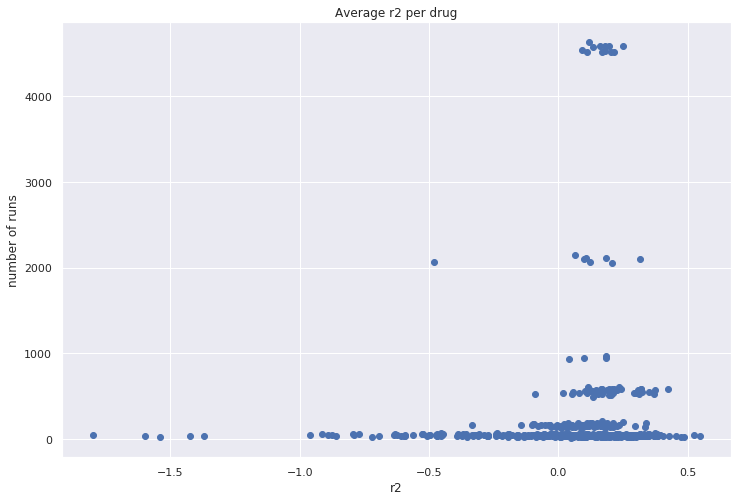

In [58]:
sns.set(font_scale=1)
fig, ax = plt.subplots(figsize=(12,8))

ax.scatter(drugs[drugs['r2_score']['mean']>-2]['r2_score']['mean'], drugs[drugs['r2_score']['mean']>-2]['runs'])
ax.set_xlabel('r2')
ax.set_ylabel('number of runs')
ax.set_title('Average r2 per drug')
#plt.savefig('Drug r2.png')

In [ ]:
low = drug_data_j[drug_data_j['Drug'].isin(one.index)]
high = drug_data_j[drug_data_j['Drug'].isin(multiple.index)]

In [68]:
# sns.set(font_scale=1)
# drugs = drug_ic[drug_ic['Quality']>-0.75].reset_index()
# g = sns.catplot(x= 'Drug', y='r2_score',data=drugs, kind='box', height=10, aspect=1.5)
# sns.swarmplot(x= 'Drug', y='r2_score',data=drugs, color='.25')
# g.set_xticklabels(rotation=45)
# plt.tight_layout()
# #plt.savefig('top drugs.png')

# Measures for overrepresentation on top datasets

In [29]:
def OR(indices, rest, top, group):
    li = []
    for i in indices:
        model_t = top[(top[group[0]]==i[0])&(top[group[1]]==i[1])].shape[0]
        nmodel_t = top[(top[group[0]]!=i[0])|(top[group[1]]!=i[1])].shape[0]
        model_r = rest[(rest[group[0]]==i[0])&(rest[group[1]]==i[1])].shape[0]
        nmodel_r = rest[(rest[group[0]]!=i[0])|(rest[group[1]]!=i[1])].shape[0]
        if model_r > 0 and nmodel_r > 0:
            li.append((model_t/model_r)/(nmodel_t/nmodel_r))
        else:
            li.append(0)
    return li

In [30]:
def top_OR(data, group, q=0.95, score='r2_score'):
    top = data[data[score] >= data[score].quantile(q)]
    counts = data[group +[score]].groupby(group).count()
    topcounts = top[group +[score]].groupby(group).count()
    topcounts['OR'] = OR(topcounts.index, data[data[score]<data[score].quantile(q)], top, group)
    return topcounts

# AJIVE rank vs r2

In [422]:
clean['ajive'] = clean['ajive'].replace(0, np.nan)

In [431]:
clean[['ajive', 'datasets', 'r2_score']].groupby(['datasets', 'ajive']).describe()

r2_score                                                     \
                  count      mean       std        min       25%       50%   
datasets ajive                                                               
1        1.0     4233.0 -0.012578  0.334589  -6.472891 -0.076418  0.032245   
         2.0     4493.0 -0.002099  0.527131 -21.885501 -0.046232  0.053314   
         3.0     4773.0 -0.003344  0.391353  -7.377194 -0.056664  0.042070   
2        1.0     4580.0  0.165135  0.257446  -5.028312  0.025414  0.149877   
         2.0     4356.0  0.140897  0.228097  -3.310827  0.011954  0.122413   
         3.0     4328.0  0.172676  0.253588  -6.609210  0.034090  0.152869   
3        1.0      888.0  0.159180  0.123577  -0.641561  0.094004  0.164534   
         2.0      972.0  0.158640  0.139071  -0.815630  0.094753  0.168807   
         3.0     1080.0  0.154984  0.134132  -0.739115  0.082795  0.162638   

                                    
                     75%       max  
datasets ajive                      
1        1.0    0.129494  0.606141  
         2.0    0.149797  0.639834  
         3.0    0.139201  0.617815  
2        1.0    0.294276  0.909735  
         2.0    0.267800  0.885810  
         3.0    0.303026  0.930501  
3        1.0    0.237729  0.503095  
         2.0    0.240297  0.527913  
         3.0    0.238418  0.516673

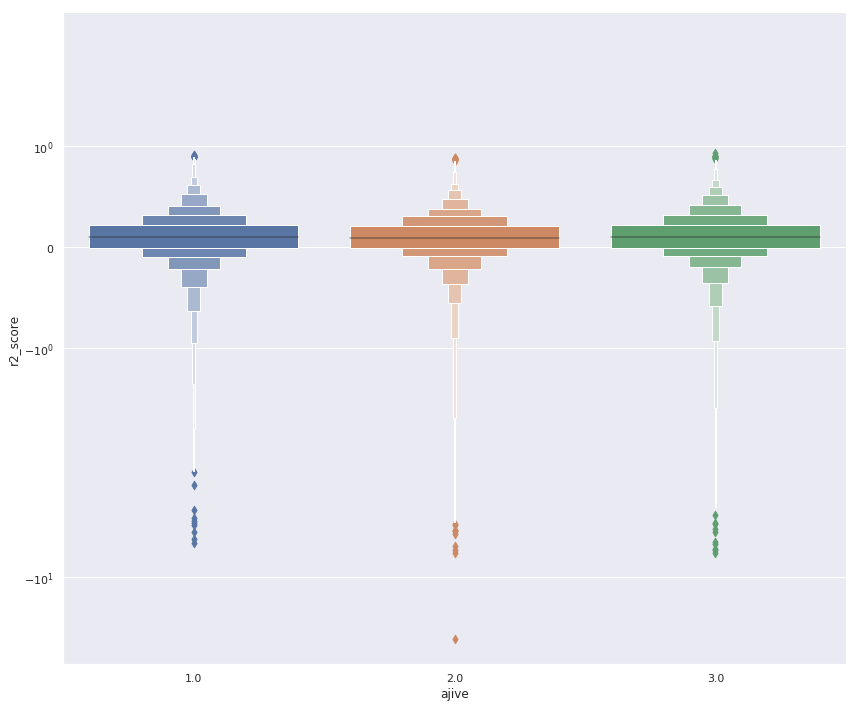

In [429]:
sns.set(font_scale=1)
g = sns.catplot(x='ajive', y='r2_score', data=clean, kind='boxen', height=10, aspect=1.2)
g.set(yscale='symlog')
g.set(ylim=(None,3))

# Datasets

In [385]:
clean[['datasets', 'r2_score']].groupby('datasets').describe()

r2_score                                                     \
            count      mean       std        min       25%       50%   
datasets                                                               
1         42002.0  0.024872  0.418576 -21.885501 -0.030621  0.060553   
2         41557.0  0.103203  0.237134  -6.609210 -0.016644  0.046320   
3          9084.0  0.109139  0.148261  -0.815630 -0.003626  0.109437   

                              
               75%       max  
datasets                      
1         0.161122  0.639834  
2         0.226202  0.930501  
3         0.221821  0.542679

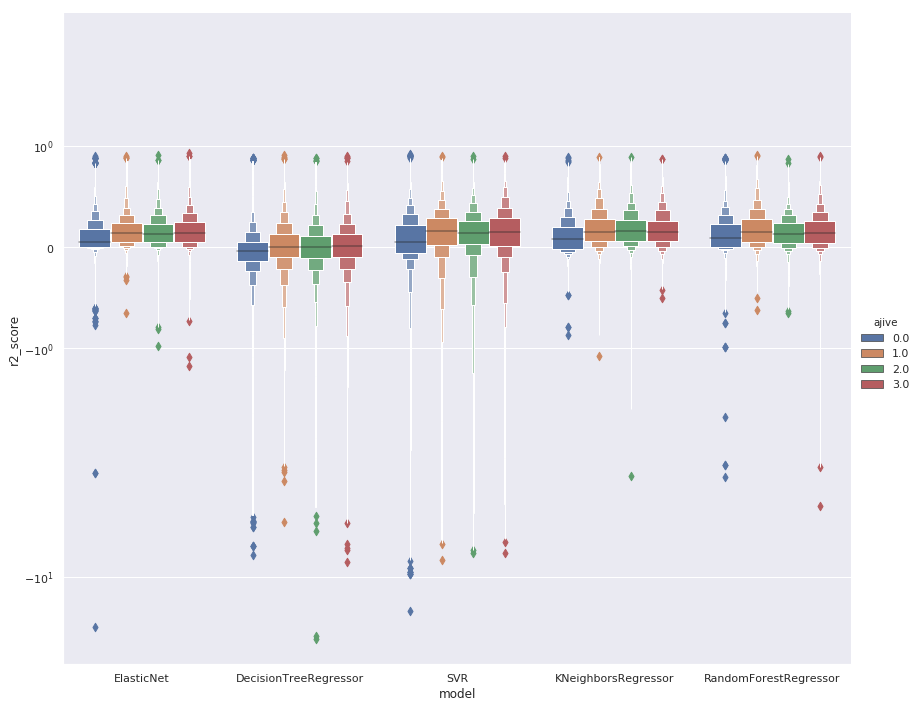

In [141]:
sns.set(font_scale=1)
lo = clean
lo['ajive'] = lo['ajive'].fillna(0)
g = sns.catplot(x='model', y='r2_score', hue='ajive', data=lo, kind='boxen', height=10, aspect=1.2)
g.set(yscale='symlog')
g.set(ylim=(None,3))
#plt.savefig('ajive-rank.png')

# Norm

In [309]:
clean['norm'] = clean['norm'].fillna('None')

In [343]:
clean[['norm','r2_score']].groupby('norm').describe()

r2_score                                           \
                       count      mean       std        min       25%   
norm                                                                    
MaxAbsScaler         12878.0  0.082773  0.316231  -9.359773 -0.004367   
MinMaxScaler         12595.0  0.087495  0.285290  -7.412272 -0.004460   
None                 42826.0  0.050768  0.372193 -21.885501 -0.039121   
QuantileTransformer  11737.0  0.101351  0.264647  -6.761819 -0.004025   
StandardScaler       12607.0  0.062919  0.272985 -18.884530 -0.008830   

                                                   
                          50%       75%       max  
norm                                               
MaxAbsScaler         0.081926  0.199371  0.903684  
MinMaxScaler         0.089511  0.206466  0.904298  
None                 0.041318  0.188078  0.920145  
QuantileTransformer  0.084237  0.231774  0.930501  
StandardScaler       0.039064  0.142386  0.909261

In [341]:
clean[['model', 'norm', 'r2_score']].groupby(('model', 'norm')).describe()['r2_score'][['mean', 'std', '50%']]

/rwthfs/rz/cluster/home/kz035322/Thesis/venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  """Entry point for launching an IPython kernel.


mean       std       50%
model                 norm                                             
DecisionTreeRegressor MaxAbsScaler        -0.117079  0.355682 -0.068622
                      MinMaxScaler        -0.101054  0.325641 -0.061574
                      None                -0.021163  0.379044 -0.008973
                      QuantileTransformer -0.084708  0.224746 -0.051868
                      StandardScaler      -0.037810  0.277576 -0.027609
ElasticNet            MaxAbsScaler         0.118721  0.133443  0.094805
                      MinMaxScaler         0.130241  0.135500  0.108442
                      None                 0.120659  0.180708  0.071259
                      QuantileTransformer  0.143853  0.177223  0.110689
                      StandardScaler       0.076730  0.265009  0.047971
KNeighborsRegressor   MaxAbsScaler         0.139611  0.180732  0.101414
                      MinMaxScaler         0.125067  0.168718  0.107653
                      None                 0.125505  0.168506  0.104482
                      QuantileTransformer  0.137668  0.175135  0.101649
                      StandardScaler       0.063866  0.140287  0.029486
RandomForestRegressor MaxAbsScaler         0.139489  0.172954  0.123740
                      MinMaxScaler         0.164439  0.179693  0.149873
                      None                 0.125628  0.170255  0.095486
                      QuantileTransformer  0.143151  0.192239  0.121106
                      StandardScaler       0.117303  0.175411  0.078325
SVR                   MaxAbsScaler         0.060015  0.610714  0.109862
                      MinMaxScaler         0.067066  0.510644  0.117916
                      None                 0.039546  0.588611  0.064552
                      QuantileTransformer  0.037081  0.490469  0.108118
                      StandardScaler       0.032768  0.480644  0.050786

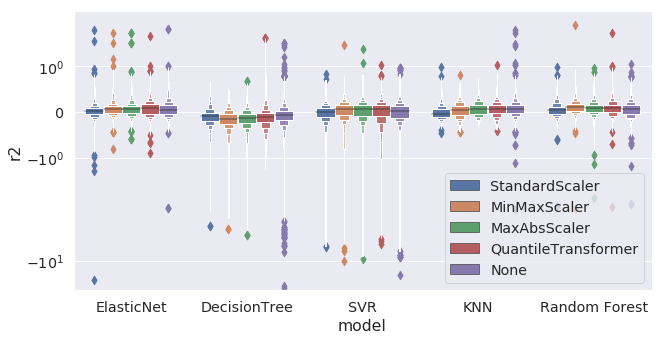

In [27]:
sns.set(font_scale=1.3)
g = sns.catplot(x='model', y='r2',hue='norm', data=clean, kind='boxen', height=5, aspect=1.9, legend=False)
g.set(ylim=(None,2.5))
g.set(yscale='symlog')
g.set_xticklabels(['ElasticNet', 'DecisionTree', 'SVR', 'KNN', 'Random Forest'])
plt.tight_layout()
plt.legend(loc='lower right')
#plt.savefig('graphs/norm-model.eps', format='eps')

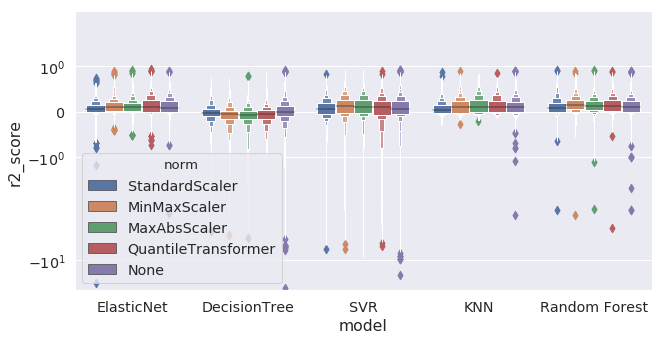

In [404]:
sns.set(font_scale=1.3)
g = sns.catplot(x='model', y='r2_score',hue='norm', data=clean, kind='boxen', height=5, aspect=1.9, legend=False)
g.set(ylim=(None,2.5))
g.set(yscale='symlog')
g.set_xticklabels(['ElasticNet', 'DecisionTree', 'SVR', 'KNN', 'Random Forest'])
plt.tight_layout()
plt.legend(loc='lower right')
#plt.savefig('graphs/norm-model.eps', format='eps')

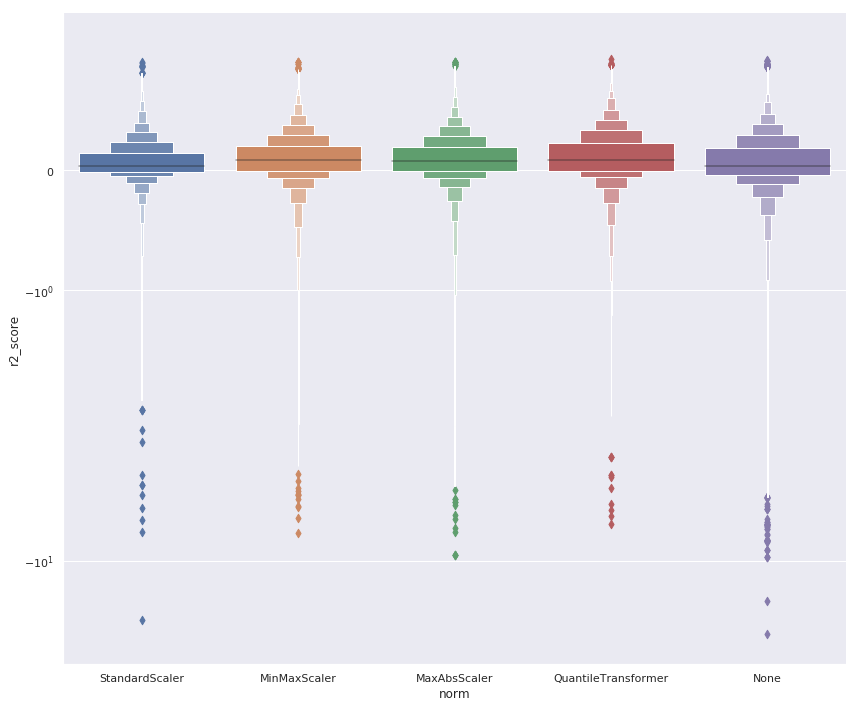

In [312]:
sns.set(font_scale=1)
g = sns.catplot(x='norm', y='r2_score', data=clean, kind='boxen', height=10, aspect=1.2)
g.set(yscale='symlog')

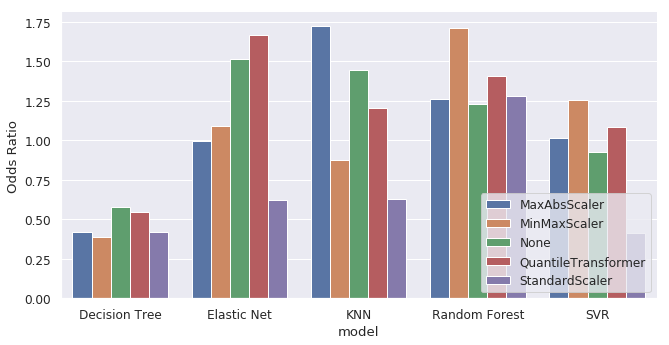

In [32]:
sns.set(font_scale=1.1)
#hue = ['DecisionTreeRegressor', 'mutual_info_regression', 'ElasticNet', 'f_regression', 'Lasso', 'RandomForestRegressor', ]
g = sns.catplot(x = 'model', y='OR', hue='norm',data=top_OR(clean, ['model', 'norm'], score='r2').reset_index(), kind='bar', height=5, aspect=1.9, legend=False)
g.set_xticklabels(['Decision Tree', 'Elastic Net', 'KNN', 'Random Forest', 'SVR'])
g.set_ylabels('Odds Ratio')
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('graphs/adjusted-top-norm.eps', format='eps')

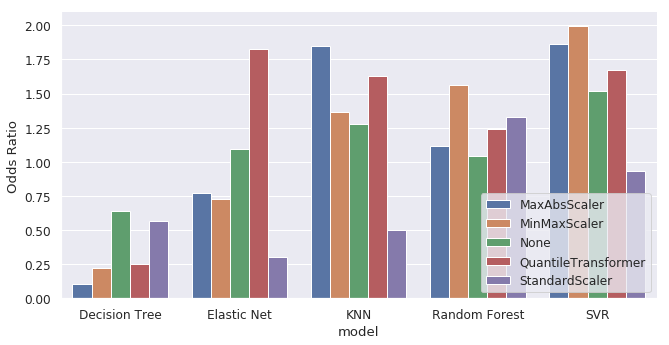

In [31]:
sns.set(font_scale=1.1)
#hue = ['DecisionTreeRegressor', 'mutual_info_regression', 'ElasticNet', 'f_regression', 'Lasso', 'RandomForestRegressor', ]
g = sns.catplot(x = 'model', y='OR', hue='norm',data=top_OR(clean, ['model', 'norm']).reset_index(), kind='bar', height=5, aspect=1.9, legend=False)
g.set_xticklabels(['Decision Tree', 'Elastic Net', 'KNN', 'Random Forest', 'SVR'])
g.set_ylabels('Odds Ratio')
plt.legend(loc='lower right')
#plt.title('Non-adjusted $r^2$')
plt.tight_layout()
plt.savefig('graphs/non-adjusted-top-norm.eps', format='eps')

# DA

In [128]:
#data = drug_data.join(ndata, on='run', rsuffix='drug')
ajive = clean[clean['ajive'].isin([1,2,3])]
feda = clean[clean['feda']==True]
neither = clean[(clean['feda']==False) & (clean['ajive']==0)]

In [129]:
da = pd.concat([ajive, feda, neither], keys=['ajive', 'feda', 'neither']).reset_index()

In [130]:
da.drop('level_1', axis=1).groupby(('model', 'level_0')).mean()[['r2_score', 'r_2_std', 'seconds']]

/rwthfs/rz/cluster/home/kz035322/Thesis/venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  """Entry point for launching an IPython kernel.


r2_score   r_2_std       seconds
model                 level_0                                  
DecisionTreeRegressor ajive   -0.017334  0.277605   1592.398001
                      feda    -0.126328  0.215493   2457.559330
ElasticNet            ajive    0.157508  0.117675   2082.421510
                      feda     0.044604  0.062616   3082.497189
KNeighborsRegressor   ajive    0.175819  0.144903   7716.761733
                      feda     0.028147  0.076566  12095.279902
RandomForestRegressor ajive    0.159158  0.158934   2930.099702
                      feda     0.049620  0.079269   5302.855640
SVR                   ajive    0.082515  2.706707   7270.094260
                      feda    -0.039601  0.623851   2559.485864

In [131]:
da[['level_0','model', 'r2_score', 'seconds']].groupby(('model', 'level_0')).describe()

/rwthfs/rz/cluster/home/kz035322/Thesis/venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  """Entry point for launching an IPython kernel.


r2_score                                 \
                                 count      mean       std        min   
model                 level_0                                           
DecisionTreeRegressor ajive    14206.0 -0.017334  0.419655 -21.885501   
                      feda      6211.0 -0.126328  0.281395  -7.627439   
ElasticNet            ajive    12199.0  0.157508  0.150464  -1.171929   
                      feda      9962.0  0.044604  0.115416  -2.684733   
KNeighborsRegressor   ajive     3324.0  0.175819  0.180000  -2.808844   
                      feda      3662.0  0.028147  0.117621  -0.790444   
RandomForestRegressor ajive     5366.0  0.159158  0.184921  -4.073783   
                      feda      5417.0  0.049620  0.114316  -1.682550   
SVR                   ajive     4477.0  0.082515  0.584417  -8.121726   
                      feda      6119.0 -0.039601  0.592913 -15.346637   

                                                                       \
                                    25%       50%       75%       max   
model                 level_0                                           
DecisionTreeRegressor ajive   -0.101120  0.003544  0.124523  0.909735   
                      feda    -0.165887 -0.074469 -0.022253  0.490484   
ElasticNet            ajive    0.050993  0.134279  0.237284  0.930501   
                      feda    -0.004795 -0.000479  0.075810  0.565486   
KNeighborsRegressor   ajive    0.062548  0.152499  0.267551  0.892240   
                      feda    -0.044813 -0.015842  0.087020  0.482487   
RandomForestRegressor ajive    0.044144  0.138006  0.256627  0.909261   
                      feda    -0.011324  0.000644  0.094773  0.509792   
SVR                   ajive    0.021775  0.149390  0.276058  0.900434   
                      feda    -0.077355 -0.029170  0.107141  0.580617   

                               seconds                                     \
                                 count          mean           std    min   
model                 level_0                                               
DecisionTreeRegressor ajive    14206.0   1592.398001   1346.168828   48.0   
                      feda      6211.0   2457.559330   2769.482182   45.0   
ElasticNet            ajive    12199.0   2082.421510   1851.261429   33.0   
                      feda      9962.0   3082.497189   2757.239333   44.0   
KNeighborsRegressor   ajive     3324.0   7716.761733   6142.964333  209.0   
                      feda      3662.0  12095.279902  12772.325543  185.0   
RandomForestRegressor ajive     5366.0   2930.099702   2624.825325   74.0   
                      feda      5417.0   5302.855640   4438.676460  120.0   
SVR                   ajive     4477.0   7270.094260  15131.921559   38.0   
                      feda      6119.0   2559.485864   5099.653390   84.0   

                                                                 
                                  25%     50%      75%      max  
model                 level_0                                    
DecisionTreeRegressor ajive     506.0  1133.0   2397.0   5610.0  
                      feda      589.0  1377.0   3492.0  15628.0  
ElasticNet            ajive     322.0  1718.0   3118.0   8144.0  
                      feda      688.0  2427.0   4789.0  11236.0  
KNeighborsRegressor   ajive    2958.0  6274.0  10694.0  28661.0  
                      feda     3265.0  8301.0  16060.0  63575.0  
RandomForestRegressor ajive     429.0  2469.0   4691.0  12599.0  
                      feda     1852.0  4173.0   7660.0  23035.0  
SVR                   ajive     431.0  1201.0   3807.0  78169.0  
                      feda      556.0  1390.0   2484.0  54702.0

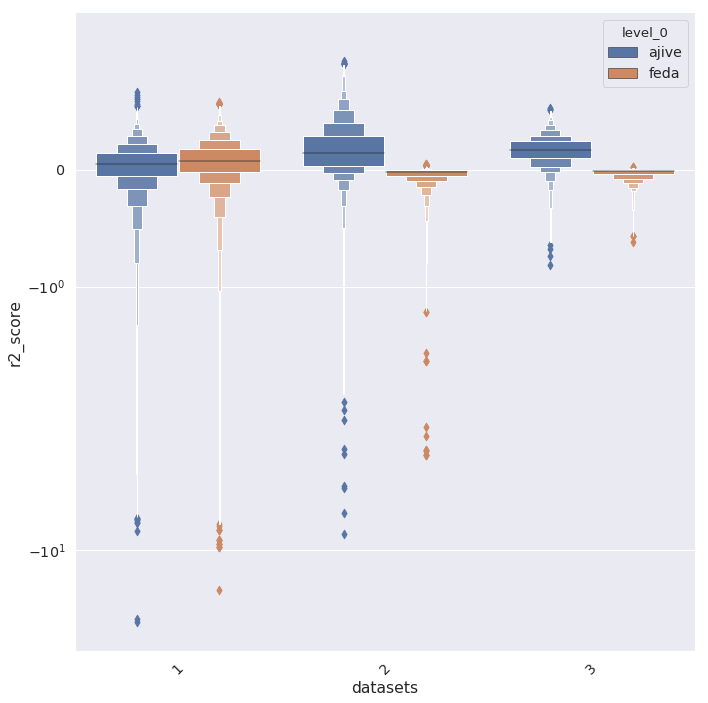

In [132]:
g = sns.catplot(x='datasets', y='r2_score', hue='level_0', data=da, height=10, kind = 'boxen', legend_out=False)
g.set_xticklabels(rotation=45)
g.set(yscale='symlog')

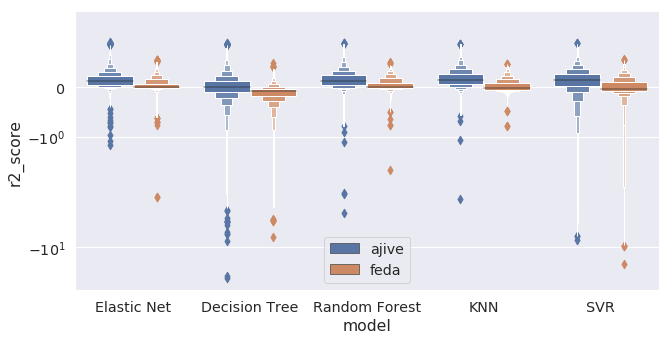

In [134]:
sns.set(font_scale=1.3)
g = sns.catplot(x='model', y='r2_score', hue='level_0', data=da, height=5, aspect=1.9, kind = 'boxen', legend=False)
plt.legend(loc='lower center')
g.set_xticklabels(['Elastic Net', 'Decision Tree', 'Random Forest', 'KNN', 'SVR'])
g.set(yscale='symlog')
plt.savefig('graphs/da-model.png')

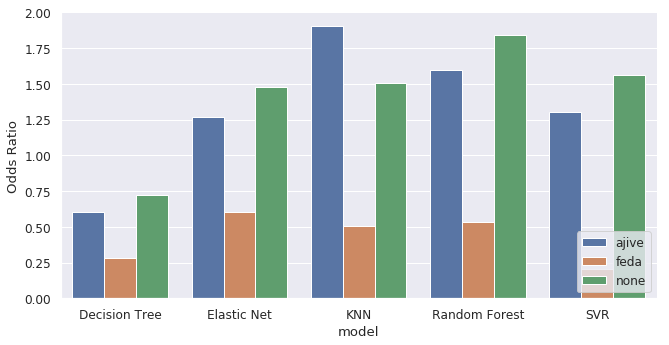

In [55]:
sns.set(font_scale=1.1)
#hue = ['DecisionTreeRegressor', 'mutual_info_regression', 'ElasticNet', 'f_regression', 'Lasso', 'RandomForestRegressor', ]
g = sns.catplot(x = 'model', y='OR', hue='da',data=top_OR(clean, ['model', 'da'], score='r2').reset_index(), kind='bar', height=5, aspect=1.9, legend=False)
g.set_xticklabels(['Decision Tree', 'Elastic Net', 'KNN', 'Random Forest', 'SVR'])
g.set_ylabels('Odds Ratio')
plt.legend(loc='lower right')
#plt.title('Adjusted $r^2$')
plt.tight_layout()
plt.savefig('graphs/adjusted-top-da.eps', format='eps')

# Best performing models

In [227]:
top = clean[clean['r2_score'] >= clean['r2_score'].quantile(0.95)]

In [200]:
counts = clean[['model', 'fs', 'r2_score']].groupby(['model', 'fs']).count()

In [201]:
topcounts = top[['model', 'fs', 'r2_score']].groupby(['model', 'fs']).count()
#topcounts['r2_score'] = topcounts['r2_score'].values*100/top.shape[0]

Most common models on the top quantile

In [203]:
topcounts['OR'] = OR(topcounts.index, clean[clean['r2_score']< clean['r2_score'].quantile(0.95)], top)

In [204]:
topcounts = topcounts.reset_index()

In [156]:
topdrugs = top[['Drug', 'datasets', 'r2_score']].groupby(['Drug', 'datasets']).describe()
topdrugs.sort_values(('r2_score', 'mean'), ascending=False).head()

r2_score                                          \
                       count      mean       std       min       25%   
Drug       datasets                                                    
Crizotinib 2           208.0  0.841211  0.075927  0.468040  0.833052   
Afatinib   2           224.0  0.792415  0.059097  0.504787  0.772359   
Nelarabine 1             1.0  0.639834       NaN  0.639834  0.639834   
Bosutinib  2           236.0  0.628307  0.064583  0.409232  0.595480   
Sunitinib  2           211.0  0.625645  0.060430  0.412292  0.592110   

                                                   
                          50%       75%       max  
Drug       datasets                                
Crizotinib 2         0.863098  0.881946  0.930501  
Afatinib   2         0.805551  0.833153  0.886975  
Nelarabine 1         0.639834  0.639834  0.639834  
Bosutinib  2         0.641958  0.674209  0.741338  
Sunitinib  2         0.638656  0.663713  0.740952

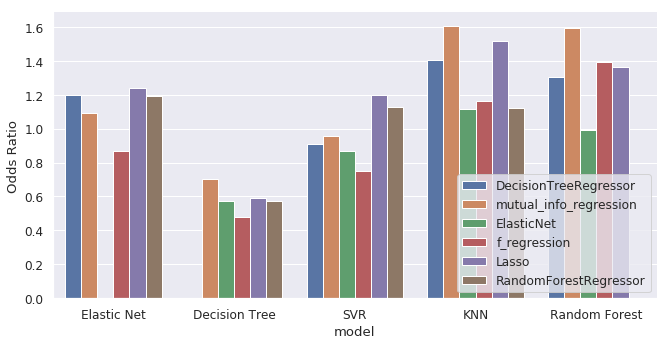

In [76]:
sns.set(font_scale=1.1)
order = ['ElasticNet', 'DecisionTreeRegressor', 'SVR','KNeighborsRegressor', 'RandomForestRegressor']
hue = ['DecisionTreeRegressor', 'mutual_info_regression', 'ElasticNet', 'f_regression', 'Lasso', 'RandomForestRegressor', ]
g = sns.catplot(x = 'model', y='OR', hue='fs', hue_order=hue, order=order, data=top_OR(clean, ['model', 'fs'], score='r2').reset_index(), kind='bar', height=5, aspect=1.9, legend=False)
g.set_xticklabels(['Elastic Net', 'Decision Tree', 'SVR', 'KNN', 'Random Forest'])
g.set_ylabels('Odds Ratio')
plt.legend(loc='lower right')
#plt.title('Adjusted $r^2$')
plt.tight_layout()
plt.savefig('graphs/adjusted-top-fs.eps', format='eps')

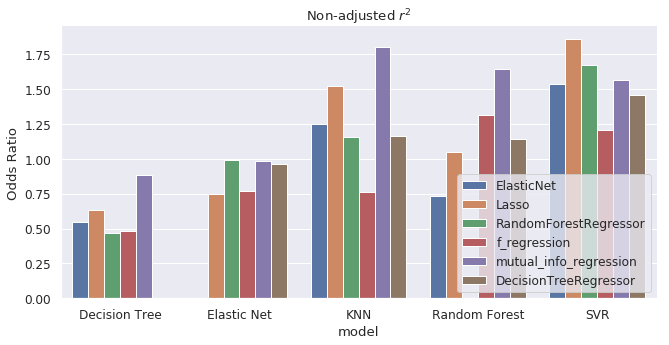

In [282]:
sns.set(font_scale=1.1)
#hue = ['DecisionTreeRegressor', 'mutual_info_regression', 'ElasticNet', 'f_regression', 'Lasso', 'RandomForestRegressor', ]
g = sns.catplot(x = 'model', y='OR', hue='fs',data=top_OR(clean, ['model', 'fs']).reset_index(), kind='bar', height=5, aspect=1.9, legend=False)
g.set_xticklabels(['Decision Tree', 'Elastic Net', 'KNN', 'Random Forest', 'SVR'])
g.set_ylabels('Odds Ratio')
plt.legend(loc='lower right')
plt.title('Non-adjusted $r^2$')
plt.tight_layout()
plt.savefig('non-adjusted.png')

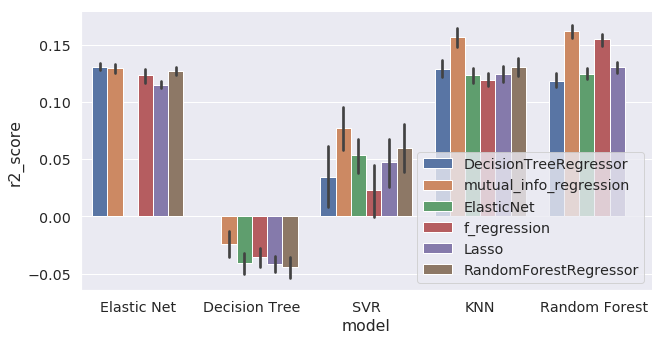

In [67]:
sns.set(font_scale=1.3)
g = sns.catplot(x = 'model', y='r2_score', hue='fs', data=clean, kind='bar', height=5, aspect=1.9, legend=False)
g.set_xticklabels(['Elastic Net', 'Decision Tree', 'SVR', 'KNN', 'Random Forest'])
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('graphs/fs-model.eps', format='eps')

# Influence of n on r2

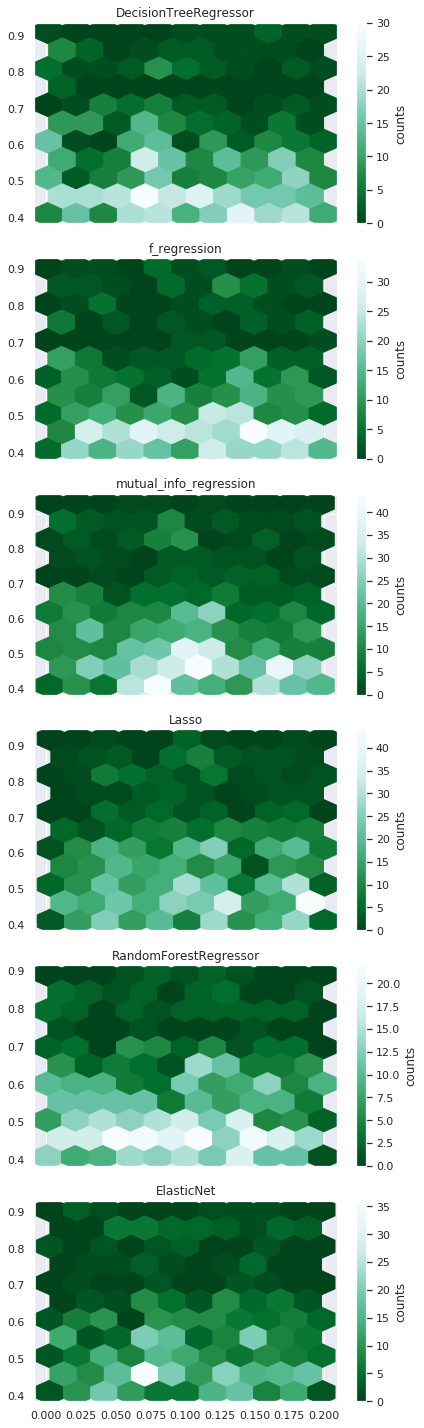

In [126]:
sns.set(font_scale=1)
lo = top
fig, ax = plt.subplots(6, 1, sharex=True,figsize=(6,20))
for i, ele in enumerate(lo['fs'].unique()):
    a = lo[lo['fs']==ele]
    hb = ax[i].hexbin(a['n'], a['r2_score'], gridsize=10, cmap=plt.cm.BuGn_r)
    cb = fig.colorbar(hb, ax=ax[i])
    cb.set_label('counts')
    ax[i].set_title(ele)
#cb = fig.colorbar(hb, ax=ax[4])
#cb.set_label('counts')
plt.tight_layout()

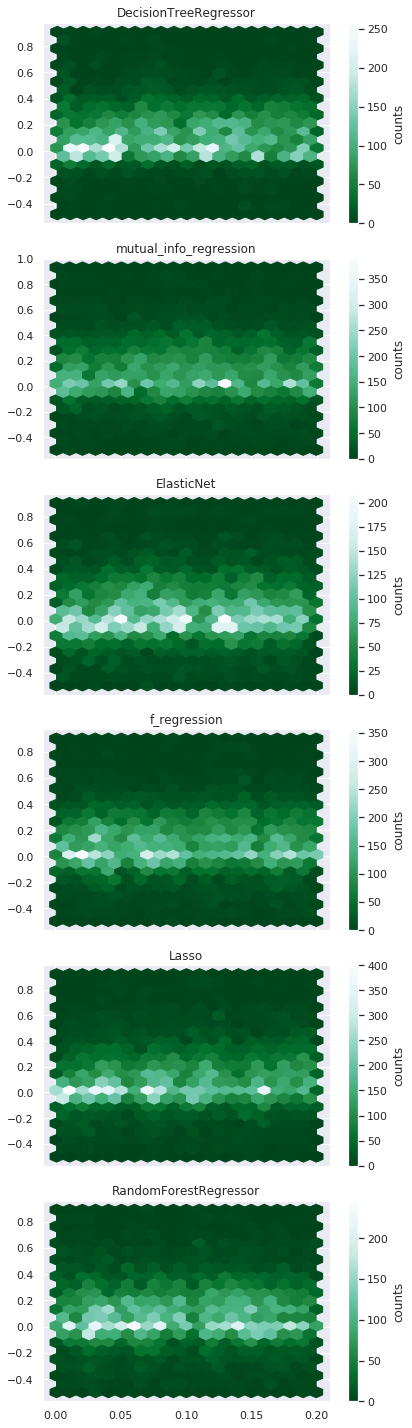

In [150]:
sns.set(font_scale=1)
lo = clean[clean['r2_score']>-0.5]
fig, ax = plt.subplots(6, 1, sharex=True,figsize=(6,20))
for i, ele in enumerate(lo['fs'].unique()):
    a = lo[lo['fs']==ele]
    hb = ax[i].hexbin(a['n'], a['r2_score'], gridsize=20, cmap=plt.cm.BuGn_r)
    cb = fig.colorbar(hb, ax=ax[i])
    cb.set_label('counts')
    ax[i].set_title(ele)
#cb = fig.colorbar(hb, ax=ax[4])
#cb.set_label('counts')
plt.tight_layout()
plt.savefig('heatmap.png')

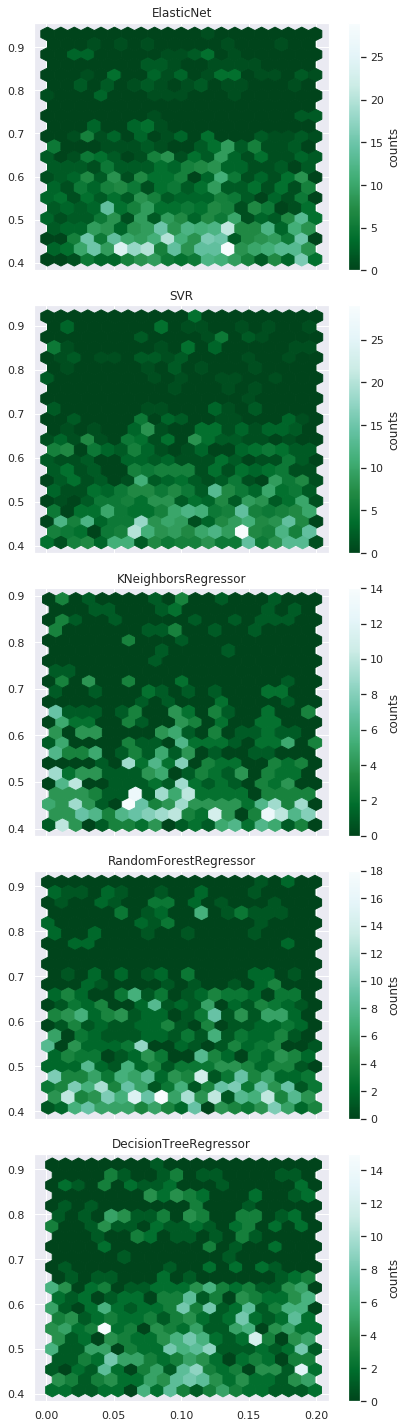

In [124]:
sns.set(font_scale=1)
lo = top
fig, ax = plt.subplots(5, 1, sharex=True,figsize=(6,20))
for i, ele in enumerate(lo['model'].unique()):
    a = lo[lo['model']==ele]
    hb = ax[i].hexbin(a['n'], a['r2_score'], gridsize=20, cmap=plt.cm.BuGn_r)
    cb = fig.colorbar(hb, ax=ax[i])
    cb.set_label('counts')
    ax[i].set_title(ele)
#cb = fig.colorbar(hb, ax=ax[4])
#cb.set_label('counts')
plt.tight_layout()

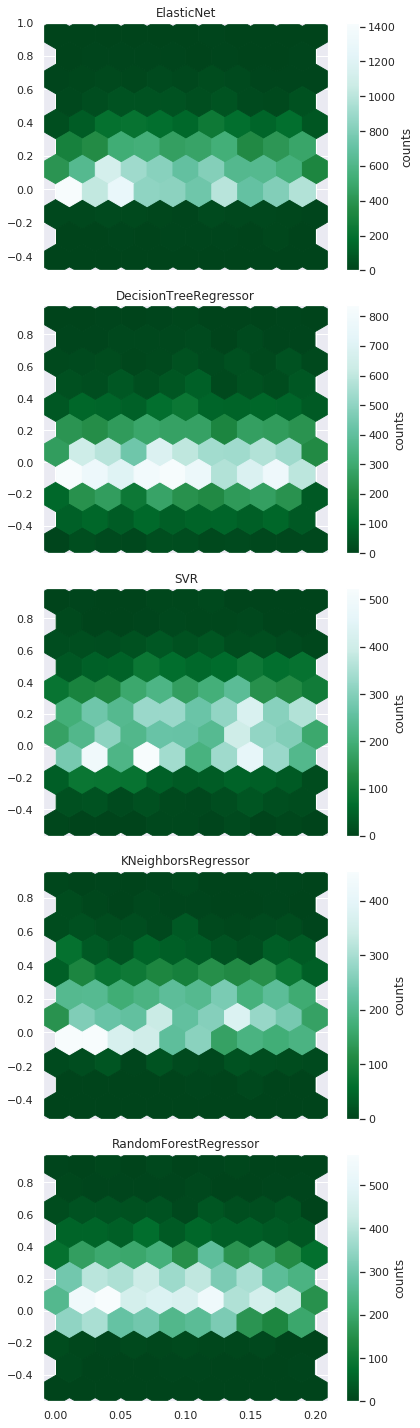

In [139]:
sns.set(font_scale=1)
lo = clean[clean['r2_score']>-0.5]
fig, ax = plt.subplots(5, 1, sharex=True,figsize=(6,20))
for i, ele in enumerate(lo['model'].unique()):
    a = lo[lo['model']==ele]
    hb = ax[i].hexbin(a['n'], a['r2_score'], gridsize=10, cmap=plt.cm.BuGn_r)
    cb = fig.colorbar(hb, ax=ax[i])
    cb.set_label('counts')
    ax[i].set_title(ele)
#cb = fig.colorbar(hb, ax=ax[4])
#cb.set_label('counts')
plt.tight_layout()

In [146]:
dr[['AUC_EC50', 'AUC_IC50']].mean()

AUC_EC50    0.380863
AUC_IC50    0.371812
dtype: float64

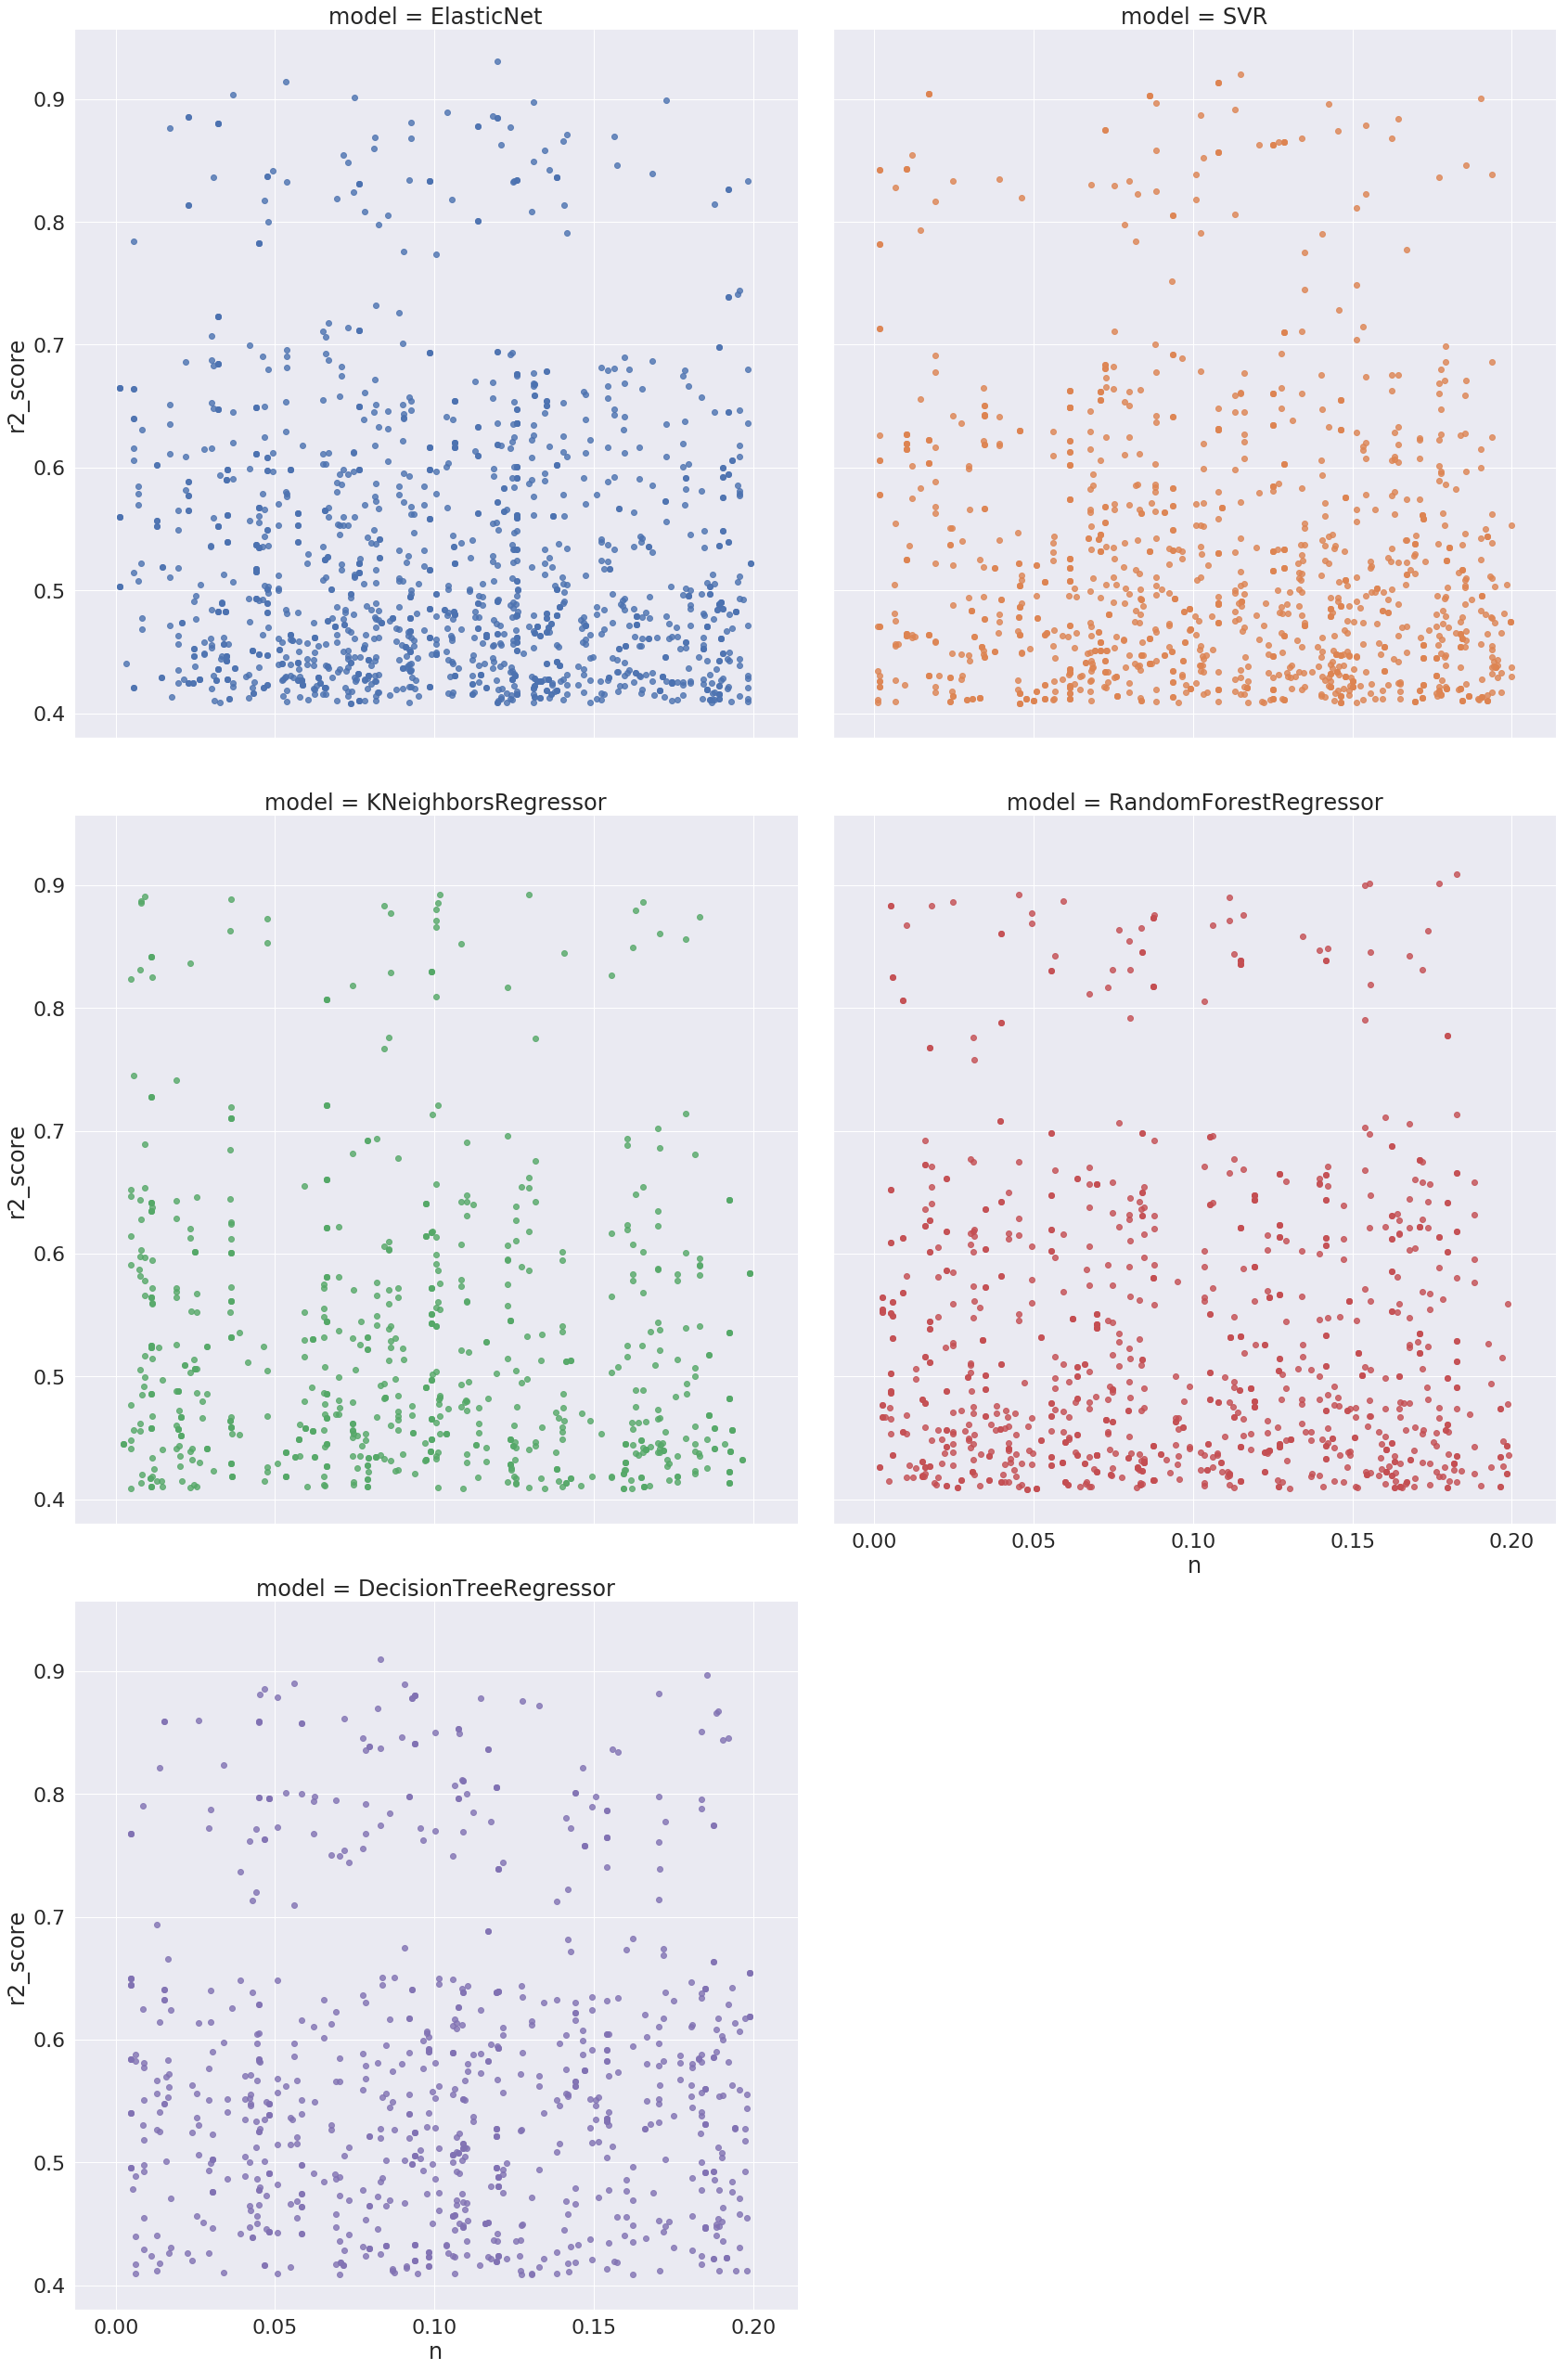

In [155]:
sns.set(font_scale=2)
g = sns.lmplot(x='n', y='r2_score', data=top, col='model', hue='model', col_wrap=2, fit_reg=False, height=12, legend=False)

plt.savefig('model vs n.png')

In [ ]:
sns.set(font_scale=2)
g = sns.lmplot(x='n', y='r2_score', data=drugs, col='model', row='fs', fit_reg=True, height=12, legend=False)
#plt.savefig('model vs n.png')

# Statistical analysis

In [78]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
m_comp = pairwise_tukeyhsd(endog=clean['r2'], groups=clean['metric_drug'], alpha=0.01)

In [80]:
m_comp.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
AUC_EC50,AUC_IC50,-0.0019,0.2645,-0.0064,0.0025,False


In [81]:
m_comp = pairwise_tukeyhsd(endog=clean['r2'], groups=clean['feda'], alpha=0.01)

In [83]:
m_comp.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
False,True,-0.1076,0.001,-0.1126,-0.1026,True


# Model hyperparameters

In [440]:
rf = clean[clean['model']=='RandomForestRegressor'][['n_estimators', 'max_depth', 'n', 'r2_score', 'seconds', 'n']]

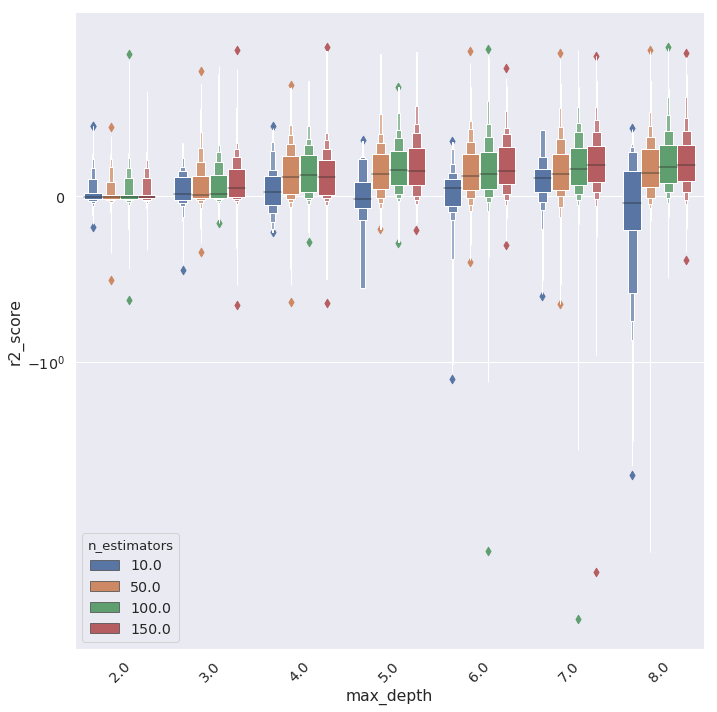

In [448]:
g = sns.catplot(x='max_depth', y='r2_score', hue='n_estimators', data=rf, height=10, kind = 'boxen', legend_out=False)
g.set_xticklabels(rotation=45)
g.set(yscale='symlog')